In [1]:
import re
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
import os
import cv2
import glob
from tqdm import tqdm
from sklearn.preprocessing import MinMaxScaler
import shutil
from decimal import Decimal, getcontext

from tensorflow.keras.layers import Input, Dense, Flatten, BatchNormalization
from tensorflow.keras.applications.resnet_v2 import ResNet50V2
# from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import SGD, Adam
# from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import tensorflow as tf

2023-04-30 11:51:57.269095: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-04-30 11:52:12.876799: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/sac0380/miniconda3/lib/python3.10/site-packages/cv2/../../lib64:
2023-04-30 11:52:12.877419: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/sac0380/miniconda3/lib/python3.10/site-packages/cv2/.

In [2]:
image_size = [224, 224] + [3,]
dir = 'images/'

In [3]:
data = pd.read_csv('TRY_final.txt', sep=',', encoding='latin-1')
data = data[data['mean_3110'].notna()]
data.head()

,AccSpeciesName,mean_14,mean_3117,mean_3106,mean_4,mean_3110,mean_26,stddev_14,stddev_3117,stddev_3106,stddev_4,stddev_3110,stddev_26,PlantGrowthForm
3,Abarema adenophora,24.422045,11.820481,NaN,0.663459,56861.990000,NaN,1.593152,1.030987,NaN,0.132959,NaN,NaN,tree
11,Abarema macradenia,23.394909,8.319237,31.670558,0.438332,16535.000000,90.000000,0.000000,0.129421,0.679612,0.000000,0.0,0.000000,tree
29,Abies alba,13.095739,7.846480,47.975610,0.499512,18.921429,70.544591,2.731756,2.738197,15.637276,0.076731,NaN,26.875742,tree
31,Abies balsamea,14.619919,16.226192,4.047670,0.457618,34.202755,7.473453,3.278028,6.272770,6.972198,0.093733,NaN,3.054439,tree
48,Abies fraseri,18.077778,5.566903,20.138400,NaN,22.801836,7.202712,3.111181,0.451749,5.774298,NaN,NaN,0.928773,tree


In [4]:
file = open('unique_species_names.txt', 'r')
Lines = file.readlines()
unique_species = [i.strip() for i in Lines]

In [7]:
import pickle

with open('leaf.pkl', 'rb') as fp:
    y_mean = pickle.load(fp)

EOFError: Ran out of input

In [5]:
# #X = []
# y_dict = dict()
# y_mean, y_std = [], []
# for image in tqdm(glob.glob("images/*")):
#     try:
#         val = data.loc[data['AccSpeciesName'] == image[7:re.search(r"\d", image).start()], 'mean_3110'].values[0]
#         y_mean.append(val)
#         if val in y_dict.keys():
#             y_dict[val].append(image)
#     except:
#         continue

In [6]:
#X = []
y_dict = dict()
y_mean, y_std = [], []
for image in tqdm(glob.glob("images/*")):
    try:
        val = data.loc[data['AccSpeciesName'] == image[7:re.search(r"\d", image).start()], 'mean_3110'].values[0]
        y_mean.append(val)
        if not os.path.exists('/home/sac0380/plant_trait_identification/training/'+str(val)):
            os.mkdir('/home/sac0380/plant_trait_identification/training/'+str(val))
        shutil.copy(image, '/home/sac0380/plant_trait_identification/training/'+str(val))
        
    except:
        continue

100%|██████████| 12782/12782 [02:32<00:00, 83.96it/s]  


In [7]:
len(y_mean)

11270

In [45]:
#image_generator = tf.keras.preprocessing.image.ImageDataGenerator(validation_split=0.2)

train_dataset = tf.keras.utils.image_dataset_from_directory('/home/sac0380/plant_trait_identification/training/', labels=y_mean, batch_size=32, label_mode='int', image_size=(224, 224), subset='training', validation_split = 0.2, seed=123)
validation_dataset = tf.keras.utils.image_dataset_from_directory('/home/sac0380/plant_trait_identification/training/', labels=y_mean, batch_size=32, label_mode='int', image_size=(224, 224), subset='validation', validation_split = 0.2, seed=123)

#train_dataset = image_generator.flow_from_directory('/home/sac0380/plant_trait_identification/training/', y_mean, batch_size=32, subset='training')
#validation_dataset = image_generator.flow_from_directory('/home/sac0380/plant_trait_identification/training/', y_mean, batch_size=32, subset='validation')

Found 11270 files belonging to 1497 classes.
Using 9016 files for training.
Found 11270 files belonging to 1497 classes.
Using 2254 files for validation.


In [46]:
maxx = np.amax(y_mean)
minn = np.amin(y_mean)
maxx, minn

(736051.0, 2.49833333333333)

In [47]:
def norm(image, label):
    global maxx
    global minn
    label = ((2*(label - minn)) / (maxx - minn)) - 1
    return image, label

In [48]:
train_dataset = train_dataset.map(norm)
validation_dataset = validation_dataset.map(norm)

In [49]:
base_model = ResNet50V2(input_shape=[224, 224] + [3,],include_top=False, weights='imagenet')
base_model.trainable = False

In [55]:
inputs = tf.keras.Input(shape=(224, 224, 3))
x = tf.keras.applications.resnet_v2.preprocess_input(inputs)
x = base_model(x, training=False)
x = tf.keras.layers.GlobalAveragePooling2D(name='avg_pool')(x)
x = BatchNormalization()(x)
#x = Dense(8, activation = 'relu')(x)
output = Dense(1)(x)
model = tf.keras.Model(inputs, output)

In [56]:
model.summary()

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 tf.math.truediv_3 (TFOpLamb  (None, 224, 224, 3)      0         
 da)                                                             
                                                                 
 tf.math.subtract_3 (TFOpLam  (None, 224, 224, 3)      0         
 bda)                                                            
                                                                 
 resnet50v2 (Functional)     (None, 7, 7, 2048)        23564800  
                                                                 
 avg_pool (GlobalAveragePool  (None, 2048)             0         
 ing2D)                                                          
                                                           

In [57]:
model.compile(loss = 'mean_absolute_error' , optimizer = Adam(learning_rate=0.00001) , metrics = ['mse', 'mae'])

In [58]:
history = model.fit(train_dataset, epochs=50, batch_size=32, validation_data=validation_dataset)

Epoch 1/50
282/282 [==============================] - 22s 71ms/step - loss: 1.1750 - mse: 2.1532 - mae: 1.1750 - val_loss: 1.0605 - val_mse: 1.8054 - val_mae: 1.0605
Epoch 2/50
282/282 [==============================] - 20s 69ms/step - loss: 1.0369 - mse: 1.7951 - mae: 1.0369 - val_loss: 0.9940 - val_mse: 1.7764 - val_mae: 0.9940
Epoch 3/50
282/282 [==============================] - 20s 70ms/step - loss: 0.9285 - mse: 1.4797 - mae: 0.9285 - val_loss: 0.9029 - val_mse: 1.5273 - val_mae: 0.9029
Epoch 4/50
282/282 [==============================] - 20s 70ms/step - loss: 0.8436 - mse: 1.2480 - mae: 0.8436 - val_loss: 0.8277 - val_mse: 1.3149 - val_mae: 0.8277
Epoch 5/50
282/282 [==============================] - 20s 70ms/step - loss: 0.7751 - mse: 1.0695 - mae: 0.7751 - val_loss: 0.7670 - val_mse: 1.1525 - val_mae: 0.7670
Epoch 6/50
282/282 [==============================] - 20s 70ms/step - loss: 0.7211 - mse: 0.9294 - mae: 0.7211 - val_loss: 0.7258 - val_mse: 1.0382 - val_mae: 0.7258
Epoc

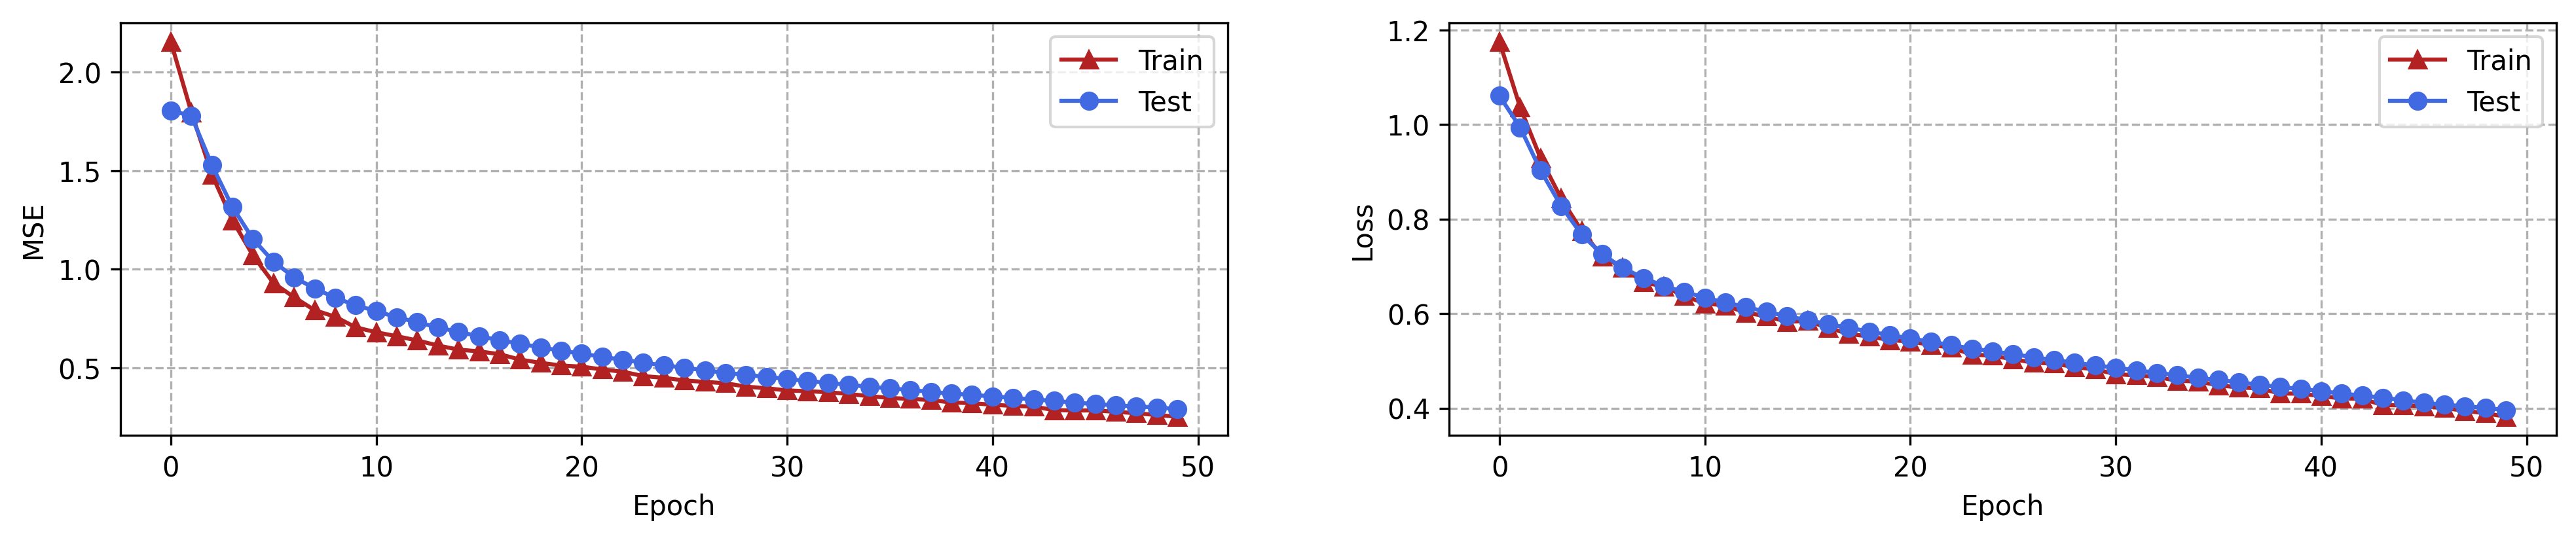

In [59]:
fig = plt.figure(figsize=(16, 6), dpi=300)

ax = fig.add_subplot(221)
ax.plot(history.history["mse"], marker="^", label = "Train", color="firebrick")
ax.plot(history.history["val_mse"], marker="o", label = "Test", color="royalblue")
ax.set_xlabel("Epoch")
ax.set_ylabel("MSE")
ax.legend()
ax.grid(True, ls="--")

ax = fig.add_subplot(222)
ax.plot(history.history["loss"], marker="^", label = "Train", color="firebrick")
ax.plot(history.history["val_loss"], marker="o", label = "Test", color="royalblue")
ax.set_xlabel("Epoch")
ax.set_ylabel("Loss")
ax.legend()
ax.grid(True, ls="--")

# ax = fig.add_subplot(223)
# ax.plot(history.history["auc"], marker="^", label = "Train", color="firebrick")
# ax.plot(history.history["val_auc"], marker="o", label = "Test", color="royalblue")
# ax.set_xlabel("Epoch")
# ax.set_ylabel("AUC")
# ax.legend()
# ax.grid(True, ls="--")

fig.show()

In [60]:
base_model.trainable = True
model.compile(loss = 'mean_absolute_error' , optimizer = Adam(learning_rate=0.000007) , metrics = ['mse', 'mae'])
history = model.fit(train_dataset, epochs=10, batch_size=32, validation_data=validation_dataset)

Epoch 1/10


2023-04-30 13:17:42.884348: W tensorflow/tsl/framework/bfc_allocator.cc:290] Allocator (GPU_0_bfc) ran out of memory trying to allocate 4.53GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2023-04-30 13:17:42.884377: W tensorflow/tsl/framework/bfc_allocator.cc:290] Allocator (GPU_0_bfc) ran out of memory trying to allocate 4.53GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2023-04-30 13:17:42.900450: W tensorflow/tsl/framework/bfc_allocator.cc:290] Allocator (GPU_0_bfc) ran out of memory trying to allocate 4.66GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2023-04-30 13:17:42.900467: W tensorflow/tsl/framework/bfc_allocator.cc:290] Allocator (GPU

281/282 [============================>.] - ETA: 0s - loss: 0.3068 - mse: 0.2124 - mae: 0.3068

2023-04-30 13:18:41.731325: W tensorflow/tsl/framework/bfc_allocator.cc:290] Allocator (GPU_0_bfc) ran out of memory trying to allocate 4.52GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2023-04-30 13:18:41.731350: W tensorflow/tsl/framework/bfc_allocator.cc:290] Allocator (GPU_0_bfc) ran out of memory trying to allocate 4.52GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2023-04-30 13:18:41.744299: W tensorflow/tsl/framework/bfc_allocator.cc:290] Allocator (GPU_0_bfc) ran out of memory trying to allocate 4.63GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2023-04-30 13:18:41.744314: W tensorflow/tsl/framework/bfc_allocator.cc:290] Allocator (GPU

282/282 [==============================] - 73s 197ms/step - loss: 0.3064 - mse: 0.2122 - mae: 0.3064 - val_loss: 0.2098 - val_mse: 0.1482 - val_mae: 0.2098
Epoch 2/10
282/282 [==============================] - 55s 193ms/step - loss: 0.1113 - mse: 0.0514 - mae: 0.1113 - val_loss: 0.0404 - val_mse: 0.0050 - val_mae: 0.0404
Epoch 3/10
282/282 [==============================] - 55s 193ms/step - loss: 0.0326 - mse: 0.0042 - mae: 0.0326 - val_loss: 0.0310 - val_mse: 0.0038 - val_mae: 0.0310
Epoch 4/10
282/282 [==============================] - 55s 194ms/step - loss: 0.0218 - mse: 0.0031 - mae: 0.0218 - val_loss: 0.0173 - val_mse: 0.0028 - val_mae: 0.0173
Epoch 5/10
282/282 [==============================] - 55s 194ms/step - loss: 0.0171 - mse: 0.0029 - mae: 0.0171 - val_loss: 0.0214 - val_mse: 0.0027 - val_mae: 0.0214
Epoch 6/10
282/282 [==============================] - 55s 194ms/step - loss: 0.0147 - mse: 0.0028 - mae: 0.0147 - val_loss: 0.0164 - val_mse: 0.0026 - val_mae: 0.0164
Epoch 7/1

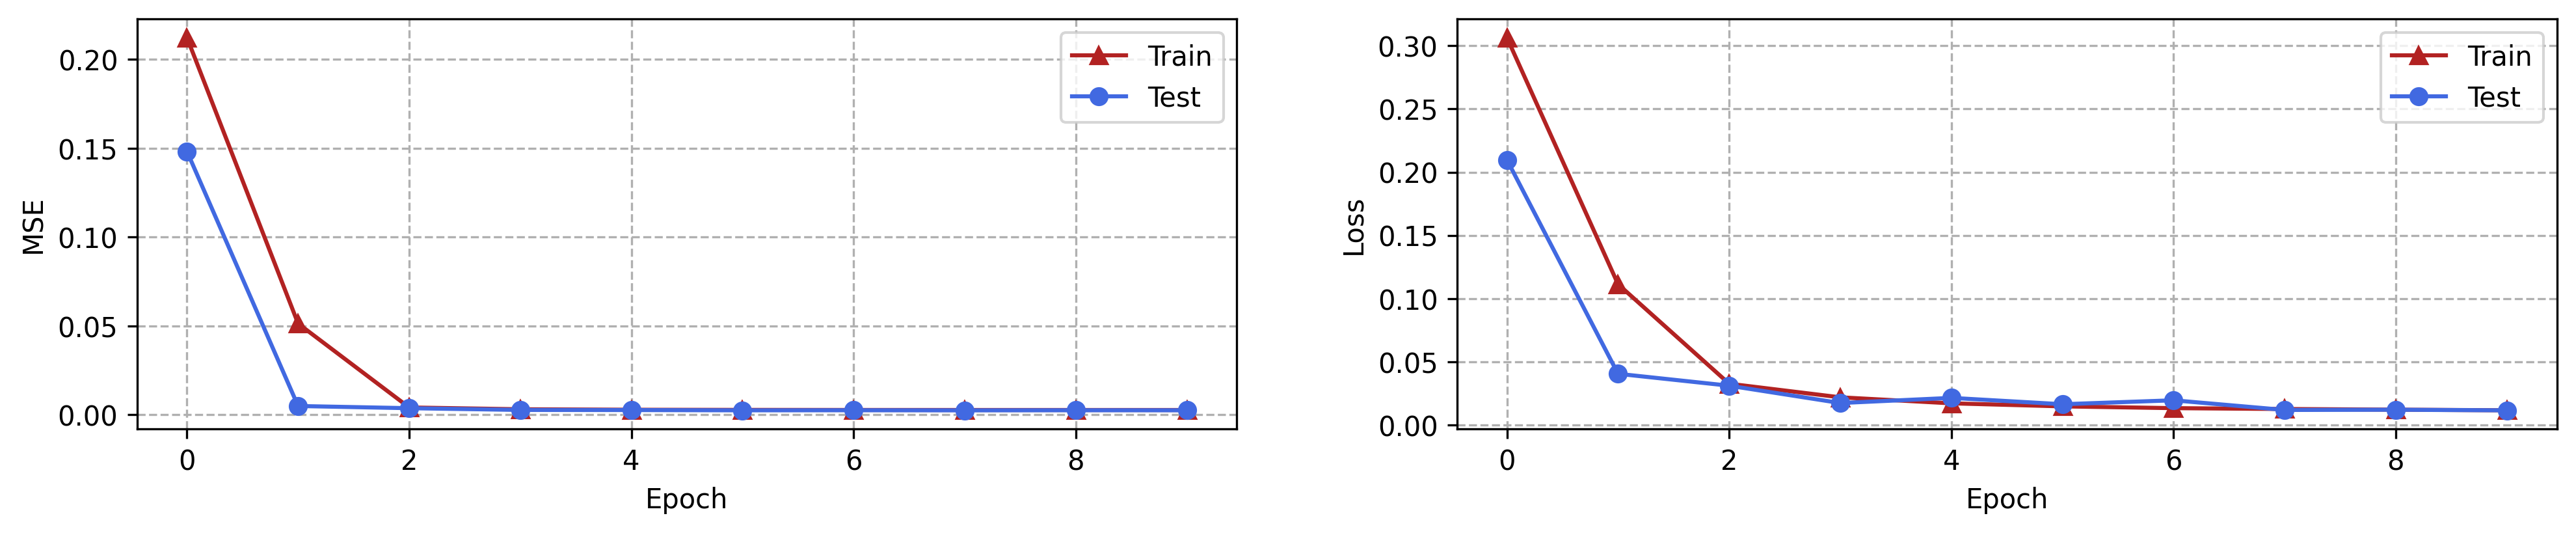

In [61]:
fig = plt.figure(figsize=(16, 6), dpi=300)

ax = fig.add_subplot(221)
ax.plot(history.history["mse"], marker="^", label = "Train", color="firebrick")
ax.plot(history.history["val_mse"], marker="o", label = "Test", color="royalblue")
ax.set_xlabel("Epoch")
ax.set_ylabel("MSE")
ax.legend()
ax.grid(True, ls="--")

ax = fig.add_subplot(222)
ax.plot(history.history["loss"], marker="^", label = "Train", color="firebrick")
ax.plot(history.history["val_loss"], marker="o", label = "Test", color="royalblue")
ax.set_xlabel("Epoch")
ax.set_ylabel("Loss")
ax.legend()
ax.grid(True, ls="--")

# ax = fig.add_subplot(223)
# ax.plot(history.history["auc"], marker="^", label = "Train", color="firebrick")
# ax.plot(history.history["val_auc"], marker="o", label = "Test", color="royalblue")
# ax.set_xlabel("Epoch")
# ax.set_ylabel("AUC")
# ax.legend()
# ax.grid(True, ls="--")

fig.show()

In [62]:
model.save("leaf_area.h5")

In [18]:
import pickle

with open('leaf.pkl', 'wb') as fp:
    pickle.dump(y_mean, fp)